## ライブラリのインポート 

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix

## APIサーバのURLと認証キーを設定

In [2]:
scoring_uri = 'http://3f682bdc-98bc-4078-a147-2689675a7ff1.eastus.azurecontainer.io/score'
key = 'Gf4I7WHEciwssUPHuG3r1K3Xu941b6lq'

## Band Gap物性予測用のcsvファイルを取得する関数

In [3]:
def csv_to_list(csv_path):
    df = pd.read_csv(csv_path)
    features_list = df.drop('Band_gap', axis=1).values.tolist()
    target_list = df['Band_gap'].values.tolist()
    
    return target_list, features_list

## APIサーバに特徴量のリストを送信し、予測値のリストを返す関数

In [4]:
def get_predict(features_list, uri, key):
    features_dict = {"data": features_list}
    input_data = json.dumps(features_dict)
    headers = {'Content-Type': 'application/json'}
    headers['Authorization'] = f'Bearer {key}' 
    resp = requests.post(uri, input_data, headers=headers)
    result = resp.text
    predict_dict=json.loads(json.loads(result))
    return predict_dict["result"]

## テストデータの読み込み、テストデータについての予測

In [5]:
test_target, test_features = csv_to_list('BG_test.csv')
test_predict = get_predict(test_features, scoring_uri, key)

## 訓練データの読み込み、訓練データについての予測

In [6]:
train_target, train_features = csv_to_list('BG_train.csv')
train_predict = get_predict(train_features, scoring_uri, key)

In [7]:
print(len(test_predict))
print(len(train_target))

947
3788


## 予測値 vs 実際の値

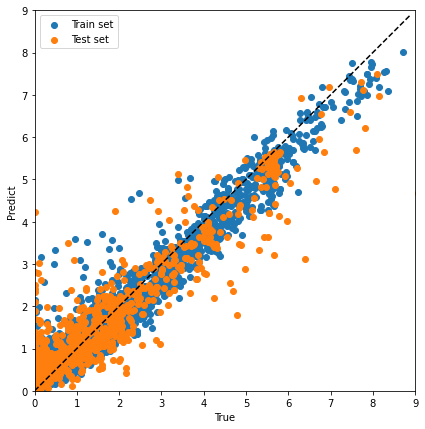

In [8]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(train_target, train_predict, label='Train set')
ax.scatter(test_target, test_predict, label='Test set')
ax.set_aspect('equal') 
x = np.arange(0, 9, 0.1)
y = x
plt.plot(x, y, c="black", linestyle="dashed")
plt.xlim(0,9)
plt.ylim(0,9)
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()
plt.show()

## Material projectからIDの材料データを取得する関数

In [9]:
def get_material_data(mpID):
    with MPRester(material_key, notify_db_version=False) as m:
        try:
            data = m.get_data(mpID)
        except Exception:
            print("error : %s" % mpID)
            exit()
    return data

## テスト材料をBand gap=2~3eVに含まれるか予測

In [10]:
true_test = [ (i > 2) & (i < 3) for i in test_target]
predict_test = [ (i > 2) & (i < 3) for i in test_predict]
positive=[]
f_negative=[]
for true, predict, features, bandgap in zip(true_test, predict_test, test_features, test_target):
    if predict:
        if true:
            correctness='〇'
        else:
            correctness='×'
        positive.append([features[0], features[1], features[2], bandgap, correctness])
    elif true and not(predict):
        f_negative.append([features[0], features[1], features[2], bandgap])
positive_df = pd.DataFrame(positive, columns=['ID', 'Formula', 'Space group', 'Band gap', 'Correctness'])
f_negative_df = pd.DataFrame(f_negative, columns=['ID', 'Formula', 'Space group', 'Band gap'])

## Band gap=2~3eVと予測された材料

In [11]:
positive_df

,ID,Formula,Space group,Band gap,Correctness
0,mp-27987,Br2F10,Cmc2_1,3.4572,×
1,mp-23715,Ba4H8,Pnma,2.8731,〇
2,mp-1198478,Br8N24,I4_1cd,2.0110,〇
3,mp-572822,Ti4O8,P2_1/m,1.6979,×
4,mp-620058,Pb12N72,Pna2_1,2.2879,〇
...,...,...,...,...,...
108,mp-572670,B16S24,P2_1/c,2.4329,〇
109,mp-13031,Mg1Se1,F-43m,2.5473,〇
110,mp-28328,Rb4I12,Pnma,1.9641,×
111,mp-560882,Se4O8,Pmc2_1,3.4647,×


## Band gap=2~3eVだが、予測されなかった材料

In [12]:
f_negative_df

,ID,Formula,Space group,Band gap
0,mp-864617,Nd2I6,P6_3/mmc,2.0193
1,mp-1009127,Mg1O1,Pm-3m,2.9211
2,mp-568441,Mg8H16,Pbca,2.0720
3,mp-1595,Nb2O5,C2/m,2.2196
4,mp-1018664,Ce2O4,P4_2/mnm,2.1576
5,mp-2789,N6O12,Im-3,2.8607
6,mp-20589,Mo4O12,Pnma,2.0181
7,mp-995393,Li2S8,P1,2.1585
8,mp-32933,Tm16S24,I-42d,2.0227
9,mp-32642,Lu16S24,I-42d,2.0776


## Band gap=2~3eVの予測の混合行列

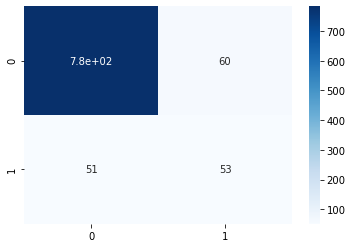

In [13]:
cm_test = confusion_matrix(true_test, predict_test)
sns.heatmap(cm_test, annot=True, cmap='Blues')
plt.show()